# Water Boiler
This is a description of the Water Boiler reactor - a homogeneous solution of Uranyl(14.7) Sulfate Solution in a hollow stainless steel sphere with a Beryllium Oxide reflector.  

The reactor was used in an experiment at LANL during the Manhattan Project.  The goal of the project was to determine the critical mass of U-235 in a homogeneous solution with various reflectors used.  

A goal of the notebook will be to make extensive use of the Nuclear Data interface of OpenMC for all of the required data.

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Material Parameters and Calculations

In [2]:
# the mass density of UO2-SO4 solution in water is needed
import scipy.interpolate

def get_UranylSulfate_solution_density(pct_us=0.299,temp=303):
    '''
    input:
    pct_us: float, weight percent UO2-SO4 in water
    temp: float, temperature in K
    
    output:
    rho_us: float, mass density (g/cc) of the solution
    
    This is derived from Table 5 of IEU-SOL-THERM-004
    
    '''
    temp = temp-273.; # convert to C
    y = [0.51, 0.399, 0.299];
    x = [15.,20.,25.,30.,35.,40.,50.];
    
    z = [[1.7959,1.7926,1.7891,1.7854,1.7816,1.777,1.7696],
        [1.5283,1.5257,1.5228,1.5199,1.5166,1.5133,1.5064],
        [1.3499,1.3479,1.3455,1.3430,1.3403,1.3376,1.3314]];
    f = scipy.interpolate.interp2d(x,y,z);
    rho_us = np.float64(f(temp,pct_us));
    return rho_us

In [3]:
# the atomic weight of enriched uranium is needed
def get_Aw_U(enrichment):
    assert (enrichment<=1.0), "enrichment should be entered as a percentage"
    # assumes a fixed ratio in the percentage of U234 and U235.
    # i.e. the enrichment process keeps these two isotopes in the
    # same relative abundance
    
    U234_to_U235_ratio = 0.0055/0.72;
    Aw_U235 = openmc.data.atomic_mass('U235');
    Aw_U234 = openmc.data.atomic_mass('U234');
    Aw_U238 = openmc.data.atomic_mass('U238');
    
    frac_235 = enrichment;
    frac_234 = frac_235*U234_to_U235_ratio;
    frac_238 = 1. - frac_235 - frac_234;
    
    aw = 1./(frac_235/Aw_U235 + frac_238/Aw_U238 + frac_234/Aw_U234);
    
    weight_frac = {};
    weight_frac['U234']=frac_234;
    weight_frac['U235']=frac_235;
    weight_frac['U238']=frac_238;
    
    return aw,weight_frac
    

In [4]:
# calculate atom densities of UO2-SO4 + H2O solution as a function
# of Uranium enrichment, water temperature and Urynal Sulfate concentration

def BoilerAtomDensities(enrich=0.1467,temp=303,conc=0.299):
    ''' 
    input:
    enrich: w/o U-235
    temp: solution temperature in K;
    conc: w/o concentration of Uranyl Sulfate in the water
    
    output:
    dictionary with the atom densities (atoms/b-cm) of all elements
    and nuclides in the solution
    
    this results in a 'not great, not terrible' agreement with the benchmark.
    must re-visit to make corrections
    
    '''
    assert (temp > 288) and (temp < 323), 'temperature not in correlation limits';
    assert (conc >= 0.299) and (conc <= 0.51), 'solution concentration not in correlation limits';
        
    
    Na = 0.60221; # Avagadro's number x10**-24
    AtomDensities = {};
    
    rho_uranyl_sulf_sol = get_UranylSulfate_solution_density(conc,temp);
    rho_water = rho_uranyl_sulf_sol*(1-conc);
    rho_uranyl = rho_uranyl_sulf_sol*conc;
    
    Aw_234 = openmc.data.atomic_mass('U234');
    Aw_235 = openmc.data.atomic_mass('U235');
    Aw_238 = openmc.data.atomic_mass('U238');
    Aw_S = openmc.data.atomic_weight('S');
    Aw_H = openmc.data.atomic_weight('H');
    Aw_O = openmc.data.atomic_weight('O');
    Aw_U,U_weight_fracs = get_Aw_U(enrich);
    
    Aw_uranyl_sulf = Aw_U + 2.*Aw_O + Aw_S + 4.*Aw_O;
    Aw_h2o = 2.*Aw_H + Aw_O;
    
    mol_density_uranyl_sulf = (rho_uranyl/Aw_uranyl_sulf)*Na;
    mol_density_h2o = (rho_water/Aw_h2o)*Na;
    AtomDensities['H']=mol_density_h2o*2.;
    AtomDensities['O']=mol_density_h2o*1.;
    AtomDensities['O']+=mol_density_uranyl_sulf*4.;
    AtomDensities['S']=mol_density_uranyl_sulf*1.;
    AtomDensities['U234']=(mol_density_uranyl_sulf)*U_weight_fracs['U234']; #wrong but better
    AtomDensities['U235']=(mol_density_uranyl_sulf)*U_weight_fracs['U235'];
    AtomDensities['U238']=(mol_density_uranyl_sulf)*U_weight_fracs['U238'];
    
    
    return AtomDensities

### Solution Material

In [5]:
sol_temp = 303; # K, Uranyl Sulfate and water solution temperature
sol_conc = 0.299; # w/o of Uranyl Sulfate in the solution
U_enrch = 0.1467; # w/o enrichment of U235 in Uranyl Sulfate

sol_atom_densities = BoilerAtomDensities(enrich=U_enrch,temp=sol_temp,conc=sol_conc);

sol = openmc.Material(name='sol');
sol.add_element('H',sol_atom_densities['H'],percent_type='ao');
sol.add_element('O',sol_atom_densities['O'],percent_type='ao');
sol.add_element('S',sol_atom_densities['S'],percent_type='ao');
sol.add_nuclide('U234',sol_atom_densities['U234'],percent_type='ao');
sol.add_nuclide('U235',sol_atom_densities['U235'],percent_type='ao');
sol.add_nuclide('U238',sol_atom_densities['U238'],percent_type='ao');
sol.add_s_alpha_beta('c_H_in_H2O');

ad_tot = 0.;
for key in sol_atom_densities:
    ad_tot+=sol_atom_densities[key];

sol.set_density('atom/b-cm',ad_tot);

### Safety Rod and Control Rod Materials
The absorber used for the control rod is Cadmium.  The control rod was a hollow brass tube with a thin cadmium sheet wrapped around the outside.  Another thin aluminum sheet was placed over the cadmium along with a cap on the tube so that the whole assembly is water tight.

#### Brass

In [6]:
brass = openmc.Material(name='brass');
brass.add_element('Fe',0.001002);
brass.add_element('Cu',0.674918);
brass.add_element('Zn',0.320956);
brass.add_element('Sn',0.001451);
brass.add_element('Pb',0.001673);
brass.set_density('g/cc',8.070);

#### Cadmium

In [7]:
cadmium = openmc.Material(name='cadmium');
cadmium.add_element('Cd',1.0);
cadmium.set_density('g/cc',8.65);

#### Aluminum

In [38]:
aluminum = openmc.Material(name='aluminum');
aluminum.add_element('Al',1.0);
aluminum.set_density('g/cc',2.6989);

### Shell Material
I will just use the nuclide and density information from PNNL-15870 Rev. 1 for Steel, Stainless 347.  The composition and atom density for the nominal 347 SS material reported in the benchmark closely match the PNNL data.

In [8]:
shell = openmc.Material(name='shell');
shell.add_element('C',0.003659);
shell.add_element('Si',0.019559);
shell.add_element('P',0.000798);
shell.add_element('S',0.000514);
shell.add_element('Cr',0.179602);
shell.add_element('Mn',0.019998);
shell.add_element('Fe',0.669338);
shell.add_element('Ni',0.102952);
shell.add_element('Nb',0.002365);
shell.add_element('Ta',0.001214);
shell.set_density('g/cc',8.0);

### Beryllium Oxide Reflector
The reported composition and density for the Beryllium Oxide blocks in the benchmark differ *significantly* from PNNL-15870. This is owing to the quick-and-dirty fabrication of the blocks (and associated reduction in material density) as well as the high impurity content.


In [9]:
beryl_ref = openmc.Material(name='beryl_ref');
beryl_ref.add_element('O',6.6210e-2);
beryl_ref.add_element('Be',6.6210e-2);
beryl_ref.add_element('B',3.0637e-7);
beryl_ref.add_element('Co',5.6202e-7);
beryl_ref.add_element('Ag',3.0706e-8);
beryl_ref.add_element('Cd',7.3662e-8);
beryl_ref.add_element('In',1.4423e-8);
beryl_ref.add_s_alpha_beta('c_Be_in_BeO');
beryl_ref.set_density('g/cc',2.75);

### Graphite Base
The beryllium semi-sphere sits in a base of graphite.  No information is given on it's composition. It probably has a trivial impact on the model result but I will just use standard data for graphite

In [10]:
grph = openmc.Material(name='grph');
grph.add_element('C',0.999999);
grph.add_element('B',0.000001);
grph.set_density('g/cc',1.7);
grph.add_s_alpha_beta('c_Graphite');

### Air outside the reactor
I don't really care about the air for its interactions with neutrons; I really just want to include it as a material so I can more fully visualize the geometry.

In [11]:
air = openmc.Material(name='air');
air.add_element('C',0.000150);
air.add_element('N',0.784431);
air.add_element('O',0.210748);
air.add_element('Ar',0.004671);
air.set_density('g/cc',0.001205);

In [39]:
materials = openmc.Materials([sol,shell,beryl_ref,grph,air,brass,cadmium,aluminum]);
materials.export_to_xml();


## Geometry
Create the geometry and plot.  Not too complicated.

### Surfaces

In [45]:
rx_origin = [0.,76.3214,0.];
ref_sphere = openmc.Sphere(y0=rx_origin[1],r=47.4210);
tank_o = openmc.Sphere(y0=rx_origin[1],r=15.3614);
tank_i = openmc.Sphere(y0=rx_origin[1],r=15.282);
graph_base_cyl = openmc.YCylinder(r=47.4210);
fill_drain_cav = openmc.YCylinder(r=4.445/2.);
fill_drain_o = openmc.YCylinder(r=2.06375);
fill_drain_i = openmc.YCylinder(r=1.905);
plate_plane = openmc.YPlane(y0=0.);
base_plane = openmc.YPlane(y0=34.4114);
sphere_center_plane = openmc.YPlane(y0=rx_origin[1]);
upper_plane = openmc.YPlane(y0=118.2314);
bbox = openmc.model.RightCircularCylinder([0.,-10.,0.],230.,60.,axis='y',boundary_type='vacuum');

# surfaces for the control rod
rod_channel_bottom = 118.2314-76.20;

cr_cyl = openmc.YCylinder(x0=-18.891,z0=0.,r=1.42875);
cr_cyl_bottom = openmc.YPlane(y0=rod_channel_bottom);

# surfaces for the safety rod
sr_right = openmc.XPlane(x0=17.3664);
sr_left = openmc.XPlane(x0=15.4614);
sr_front = openmc.ZPlane(z0=7.62/2.);
sr_back = openmc.ZPlane(z0=-7.62/2.);

# top plane for cr/sr
rod_channel_top = openmc.YPlane(y0=200.);
rod_length = 76.20;

sr_wd = 76.20;# cm, distance from fully inserted
cr_wd = 0.1; # cm, distance from fully inserted

cr_bottom = openmc.YPlane(y0=(rod_channel_bottom+cr_wd));
cr_top = openmc.YPlane(y0=(rod_channel_bottom+cr_wd+rod_length));

sr_bottom = openmc.YPlane(y0=(rod_channel_bottom+sr_wd));
sr_top = openmc.YPlane(y0=(rod_channel_bottom+sr_wd+rod_length));

cr_brass_o = openmc.YCylinder(x0=-18.891,z0=0.,r=0.9525);
cr_brass_i = openmc.YCylinder(x0=-18.891,z0=0.,r=0.7000);
cr_cd_o = openmc.YCylinder(x0=-18.891,z0=0.0,r=1.03375);

# rectangular prism doesn't appear to be working with axis='y'.
#sr_al_o = openmc.model.rectangular_prism(0.5,6.55,axis='y',origin=[16.4139,0.]);
#sr_al_i = openmc.model.rectangular_prism(0.24384,6.35,axis='y',origin=[16.4139,0.]);

# try using RPPs


KeyError: 'ZPlane'

### Cells

In [40]:
colors = {}
colors[grph]='black';
colors[shell]='silver';
colors[sol]='cadetblue';
colors[beryl_ref]='olive';
colors[air]='lightskyblue';
colors[brass]='goldenrod';
colors[cadmium]='whitesmoke';
colors[aluminum]='cyan';

In [15]:
core = openmc.Cell();
core.fill = sol;
core.region = (-tank_i) | (-fill_drain_i) & -bbox

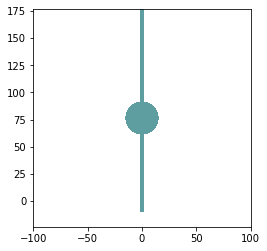

In [16]:

root = openmc.Universe();
root.add_cell(core);

root.plot(origin=rx_origin,width=[200., 200.],pixels=[800,800],
         color_by='material',colors=colors);

In [17]:
steel_tank_and_pipe = openmc.Cell();
steel_tank_and_pipe.fill = shell;
#steel_tank_and_pipe.region = (+tank_i & -tank_o & ~(-fill_drain_i)) | \
#                             (+fill_drain_i & -fill_drain_o & +tank_i) & -bbox
steel_tank_and_pipe.region = (+tank_i & -tank_o & ~(-fill_drain_i)) | \
                             (+fill_drain_i & -fill_drain_o & +tank_i) & -bbox;

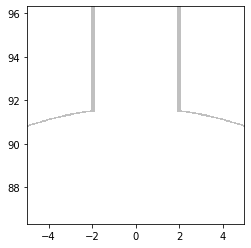

In [18]:
root = openmc.Universe();
root.add_cell(steel_tank_and_pipe);
root.plot(origin=[0.,76.3214+15.,0.],width=[10., 10.],pixels=[400,400],
         color_by='material',colors=colors);
# moved the origin around so the plot can resolve all surface areas in question

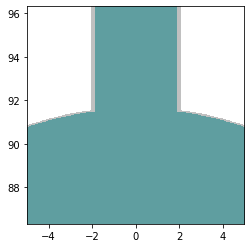

In [19]:
root = openmc.Universe();
root.add_cells([core,steel_tank_and_pipe]);
root.plot(origin=[0.,76.3214+15.,0.],width=[10., 10.],pixels=[400,400],
         color_by='material',colors=colors);
# moved the origin around so the plot can resolve all surface areas in question

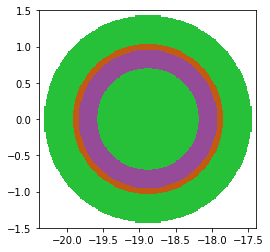

In [20]:
# make a universe for the control rod
cr_brass = openmc.Cell();
cr_brass.fill = brass;
cr_brass.region = +cr_brass_i & -cr_brass_o & +cr_bottom & -cr_top;

cr_cd = openmc.Cell();
cr_cd.fill = cadmium;
cr_cd.region = +cr_brass_o & -cr_cd_o & +cr_bottom & -cr_top;

cr_air = openmc.Cell();
cr_air.fill = air;
cr_air.region = +cr_cyl_bottom & -rod_channel_top & -cr_cyl & ~cr_cd.region & ~cr_brass.region

cr_univ = openmc.Universe();
cr_univ.add_cells([cr_brass,cr_cd,cr_air]);
cr_univ.plot(origin=[-18.891,76.,0.],width=[3.,3.],pixels=[200,200],
            color_by='material',basis='xz');


In [41]:
# make a universe for the safety rod
sr_al = openmc.Cell();
sr_al.fill = aluminum;
sr_al.region = -sr_al_o & +sr_al_i & -sr_top & +sr_bottom;

sr_univ = openmc.Universe();
sr_univ.add_cells([sr_al]);
sr_univ.plot(origin=[16.4139,0.], width=[10.,10.],pixels=[200,200],color_by='material',basis='xz');

NameError: name 'sr_al_o' is not defined

In [21]:
cr = openmc.Cell();
cr.fill = cr_univ;
cr.region = -cr_cyl & +cr_cyl_bottom & -rod_channel_top;

sr = openmc.Cell();
sr.fill = air;
sr.region = +sr_left & -sr_right & +cr_cyl_bottom & -upper_plane & -sr_front & +sr_back;

ref = openmc.Cell();
ref.fill = beryl_ref;
ref.region = ((+tank_o & +fill_drain_o) & -ref_sphere & +base_plane & -upper_plane) & ~cr.region & ~sr.region;

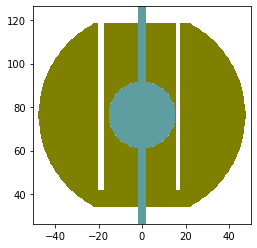

In [22]:
root = openmc.Universe();
root.add_cells([ref,core,steel_tank_and_pipe]);
root.plot(origin=rx_origin,width=[100., 100.],pixels=[400,400],
         color_by='material',colors=colors);

In [23]:
graph_base = openmc.Cell();
graph_base.fill = grph;
graph_base.region = ((-graph_base_cyl & +plate_plane & -base_plane & +fill_drain_o) |
                     (-graph_base_cyl & +ref_sphere & +base_plane & -sphere_center_plane));

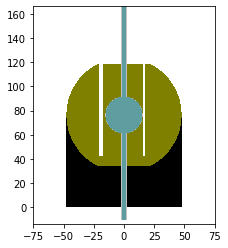

In [24]:
root = openmc.Universe();
root.add_cells([graph_base,ref,core,steel_tank_and_pipe]);
root.plot(origin=rx_origin,width=[150., 180.],pixels=[800,800],
         color_by='material',colors=colors);

In [25]:
outside = openmc.Cell();
outside.fill = air;
outside.region = -bbox & (+graph_base_cyl | (+ref_sphere & -upper_plane) | 
                         (+upper_plane & +fill_drain_o & ~cr.region ))

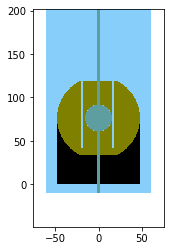

In [26]:
root = openmc.Universe();
root.add_cells([graph_base,ref,core,steel_tank_and_pipe,outside,cr,sr]);
root.plot(origin=rx_origin,width=[150, 250.],pixels=[800,800],
         color_by='material',colors=colors);

In [27]:
geometry = openmc.Geometry();
geometry.root_universe = root;
geometry.export_to_xml();

## Tallies

In [28]:
cell_filter = openmc.CellFilter(core);
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

abs_core = openmc.Tally(name='abs_core');
abs_core.scores = ['absorption'];
abs_core.filters = [cell_filter,energy_filter];

fission = openmc.Tally(name='fission');
fission.scores = ['fission'];
fission.filters = [cell_filter,energy_filter];

fission_by_nuclide = openmc.Tally(name='fission_by_nuclide');
fission_by_nuclide.scores = ['fission'];
fission_by_nuclide.nuclides = ['U234','U235','U238'];
fission_by_nuclide.filters = [cell_filter,energy_filter];

capture = openmc.Tally(name='capture');
capture.scores = ['(n,gamma)'];
capture.filters = [cell_filter,energy_filter];

capture_by_nuclide = openmc.Tally(name='capture_by_nuclide');
capture_by_nuclide.scores = ['(n,gamma)'];
capture_by_nuclide.nuclides = ['U234','U238','H1','O16','S32'];
capture_by_nuclide.filters = [cell_filter,energy_filter];


flux = openmc.Tally(name='flux');
flux.scores = ['flux'];
flux.filters = [cell_filter,energy_filter];

tallies = openmc.Tallies([abs_core, flux,
                          fission, capture,
                          fission_by_nuclide,
                          capture_by_nuclide]);
tallies.export_to_xml();


In [29]:
settings = openmc.Settings();
settings.batches = 800;
settings.inactive = 100;
settings.particles = 25000;

R = 15.;
y_org = 76.3214;

bounds = [-R,-R+y_org,-R,R,R+y_org,R];
uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                                   only_fissionable=True);
settings.source = openmc.source.Source(space=uniform_dist);

#settings.temperature['method']='interpolation';

settings.export_to_xml();

In [30]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       50/1    0.98456
       51/1    1.00188
       52/1    1.00532
       53/1    0.98818
       54/1    1.00038
       55/1    1.00299
       56/1    0.99146
       57/1    0.99827
       58/1    1.00899
       59/1    0.99289
       60/1    1.00850
       61/1    1.00417
       62/1    0.99324
       63/1    0.99719
       64/1    0.99067
       65/1    1.00722
       66/1    0.99574
       67/1    0.99654
       68/1    0.99451
       69/1    1.00009
       70/1    0.98575
       71/1    0.99138
       72/1    1.00338
       73/1    0.99955
       74/1    0.99072
       75/1    0.98359
       76/1    1.00534
       77/1    0.99248
       78/1    0.98996
       79/1    1.00336
       80/1    1.00034
       81/1    1.00575
       82/1    0.99926
       83/1    0.99419
       84/1    1.00040
       85/1    1.00080
       86/1    1.00318
       87/1    0.99779
       88/1    0.99393
       89/1    0.98771
       90/1    0.98796
       91/1    1.00306
       92/1    0.98777
       93/1

      255/1    0.98205    0.99864 +/- 0.00072
      256/1    1.00099    0.99865 +/- 0.00071
      257/1    0.98869    0.99859 +/- 0.00071
      258/1    0.99998    0.99860 +/- 0.00071
      259/1    1.00239    0.99862 +/- 0.00070
      260/1    0.99194    0.99858 +/- 0.00070
      261/1    1.00714    0.99863 +/- 0.00070
      262/1    0.99241    0.99859 +/- 0.00070
      263/1    0.99618    0.99858 +/- 0.00069
      264/1    0.99624    0.99857 +/- 0.00069
      265/1    0.99600    0.99855 +/- 0.00068
      266/1    1.00115    0.99857 +/- 0.00068
      267/1    0.99161    0.99852 +/- 0.00068
      268/1    1.00521    0.99856 +/- 0.00067
      269/1    0.99817    0.99856 +/- 0.00067
      270/1    0.99634    0.99855 +/- 0.00067
      271/1    0.97623    0.99842 +/- 0.00067
      272/1    1.01135    0.99849 +/- 0.00068
      273/1    1.00011    0.99850 +/- 0.00067
      274/1    1.00486    0.99854 +/- 0.00067
      275/1    0.99861    0.99854 +/- 0.00066
      276/1    1.01624    0.99864 

      434/1    1.01428    0.99879 +/- 0.00047
      435/1    0.99123    0.99877 +/- 0.00047
      436/1    1.00155    0.99878 +/- 0.00047
      437/1    1.00093    0.99878 +/- 0.00047
      438/1    0.99594    0.99877 +/- 0.00047
      439/1    0.99025    0.99875 +/- 0.00047
      440/1    0.99357    0.99873 +/- 0.00046
      441/1    0.99315    0.99872 +/- 0.00046
      442/1    0.99342    0.99870 +/- 0.00046
      443/1    0.99852    0.99870 +/- 0.00046
      444/1    1.00301    0.99871 +/- 0.00046
      445/1    0.99083    0.99869 +/- 0.00046
      446/1    0.99152    0.99867 +/- 0.00046
      447/1    1.01068    0.99871 +/- 0.00046
      448/1    1.00056    0.99871 +/- 0.00046
      449/1    0.98768    0.99868 +/- 0.00046
      450/1    1.00527    0.99870 +/- 0.00046
      451/1    0.98430    0.99866 +/- 0.00046
      452/1    0.98422    0.99862 +/- 0.00046
      453/1    1.00869    0.99864 +/- 0.00046
      454/1    1.00661    0.99867 +/- 0.00046
      455/1    0.99473    0.99866 

      613/1    0.98449    0.99843 +/- 0.00038
      614/1    1.00661    0.99845 +/- 0.00038
      615/1    0.99791    0.99845 +/- 0.00038
      616/1    1.00195    0.99845 +/- 0.00038
      617/1    0.99073    0.99844 +/- 0.00038
      618/1    0.97944    0.99840 +/- 0.00038
      619/1    0.98166    0.99837 +/- 0.00038
      620/1    1.00040    0.99837 +/- 0.00038
      621/1    0.99481    0.99837 +/- 0.00038
      622/1    0.99973    0.99837 +/- 0.00038
      623/1    0.99552    0.99836 +/- 0.00038
      624/1    0.98569    0.99834 +/- 0.00038
      625/1    0.99665    0.99834 +/- 0.00038
      626/1    1.00438    0.99835 +/- 0.00038
      627/1    1.00772    0.99837 +/- 0.00037
      628/1    0.98976    0.99835 +/- 0.00037
      629/1    0.97350    0.99830 +/- 0.00038
      630/1    0.99752    0.99830 +/- 0.00038
      631/1    0.99852    0.99830 +/- 0.00038
      632/1    1.00174    0.99831 +/- 0.00037
      633/1    1.00020    0.99831 +/- 0.00037
      634/1    1.00942    0.99833 

      792/1    1.00792    0.99853 +/- 0.00032
      793/1    1.00358    0.99854 +/- 0.00032
      794/1    1.01394    0.99856 +/- 0.00032
      795/1    0.98884    0.99855 +/- 0.00032
      796/1    1.00309    0.99856 +/- 0.00032
      797/1    1.00598    0.99857 +/- 0.00032
      798/1    1.00023    0.99857 +/- 0.00032
      799/1    1.00430    0.99858 +/- 0.00032
      800/1    1.02135    0.99861 +/- 0.00032
 Creating state point statepoint.800.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.6811e+01 seconds
   Reading cross sections          = 1.6620e+01 seconds
 Total time in simulation          = 2.0509e+03 seconds
   Time in transport only          = 2.0456e+03 seconds
   Time in inactive batches        = 1.7873e+02 seconds
   Time in active batches          = 1.8721e+03 seconds
   Time synchronizing fission bank = 2.3730e+00 seconds
     Sampling source sites         = 2.0190e+00 seconds
     SEND/RECV s

In [31]:
sp = openmc.StatePoint('statepoint.800.h5');
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	abs_core
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 6: Tally
 	ID             =	6
 	Name           =	flux
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength,
 2: Tally
 	ID             =	2
 	Name           =	fission
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['fission']
 	Estimator      =	tracklength,
 4: Tally
 	ID             =	4
 	Name           =	capture
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['(n,gamma)']
 	Estimator      =	tracklength,
 3: Tally
 	ID             =	3
 	Name           =	fission_by_nuclide
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	U234 U235 U238
 	Scores         =	['fission']
 	Estimator      =	tracklength,
 5: Tally
 	ID             =	5

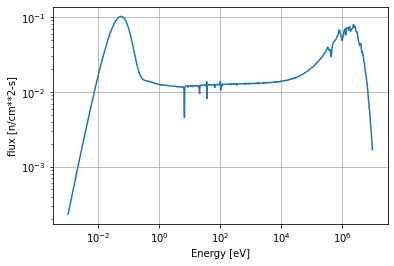

In [32]:
flux = sp.get_tally(name='flux');
flux_df = flux.get_pandas_dataframe();
flux_vals = flux_df['mean'].to_numpy();

energy_x = 0.5*(energy_bins[0:-1] + energy_bins[1:]);

plt.loglog(energy_x,flux_vals);
plt.grid();
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');

Notice the sharp dip in flux at about 10-20 eV.  Presumably this is a resonance absorption peak for something in the core; I'd guess U-238.

The logical nuclide to suspect is U-238 but there is no good reason not to at least look at the other cross sections, so I will import and plot the capture cross sections for all of the isotopes.

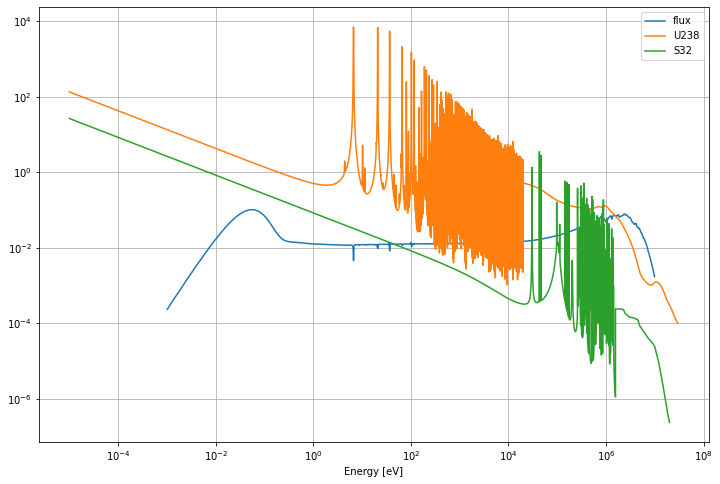

In [34]:
#OMC_DATA = "/home/sblair/OMC_DATA/endfb71_hdf5"
OMC_DATA = "/home/stu/OMC_DATA/endfb71_hdf5"

u238_path = OMC_DATA + "/U238.h5";
u238 = openmc.data.IncidentNeutron.from_hdf5(u238_path);
u238_capture = u238[102];

s32_path = OMC_DATA + "/S32.h5";
s32 = openmc.data.IncidentNeutron.from_hdf5(s32_path);
s32_capture = s32[102];

plt.rcParams['figure.figsize']=[12,8];
plt.loglog(energy_x,flux_vals,label='flux');
plt.loglog(u238_capture.xs['294K'].x,u238_capture.xs['294K'].y,label='U238');
plt.loglog(s32_capture.xs['294K'].x,s32_capture.xs['294K'].y,label='S32');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');



Notice the alignment of the first 3 large resonance peaks of U-238 with the first 3 prominent "dips" in flux.  I plotted S-32 just for reference; I wanted to see the energy at which its resonance region starts.  In general, the resonance region for light isotopes begins at a higher energy than the resonance region for heavy isotopes.  S-32 is the only other isotope besides the Uranium isotopes that has a reasonably high mass number and non-trivial atom density.  

We included U-234 in the model and that must be for a reason.  Let's plot U-234 capture cross section along with U-238 and the flux to see if that might be a contributor.

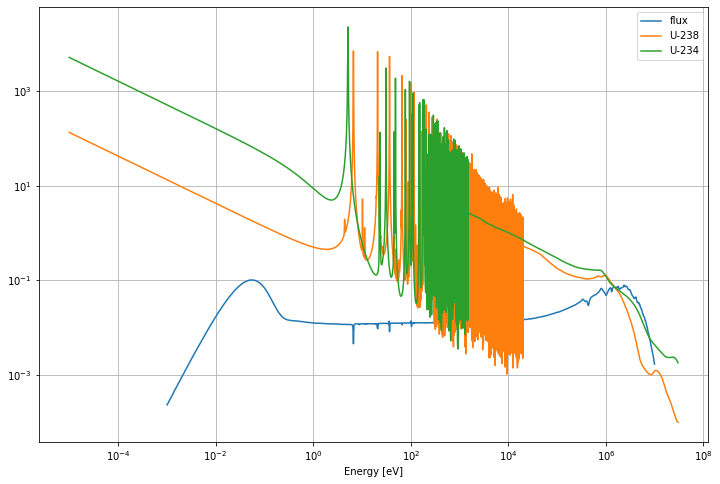

In [35]:
u234_path = OMC_DATA + "/U234.h5";
u234 = openmc.data.IncidentNeutron.from_hdf5(u234_path);
u234_capture = u234[102];

plt.rcParams['figure.figsize']=[12,8];
plt.loglog(energy_x,flux_vals,label='flux');
plt.loglog(u238_capture.xs['294K'].x,u238_capture.xs['294K'].y,label='U-238');
plt.loglog(u234_capture.xs['294K'].x,u234_capture.xs['294K'].y,label='U-234');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');

Ahh!  So it turns out that U-234 has an even bigger and lower-lying capture resonance than U-238.  Without a doubt this is why neutron transport models include this (small) isotope.

In [36]:
capture_by_nuclide = sp.get_tally(name='capture_by_nuclide');
capture_by_nuclide_df = capture_by_nuclide.get_pandas_dataframe();

capture_U234 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='U234']['mean'].to_numpy();
capture_U238 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='U238']['mean'].to_numpy();
capture_H1 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='H1']['mean'].to_numpy();
capture_S32 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='S32']['mean'].to_numpy();
capture_O16 = capture_by_nuclide_df[capture_by_nuclide_df['nuclide']=='O16']['mean'].to_numpy();

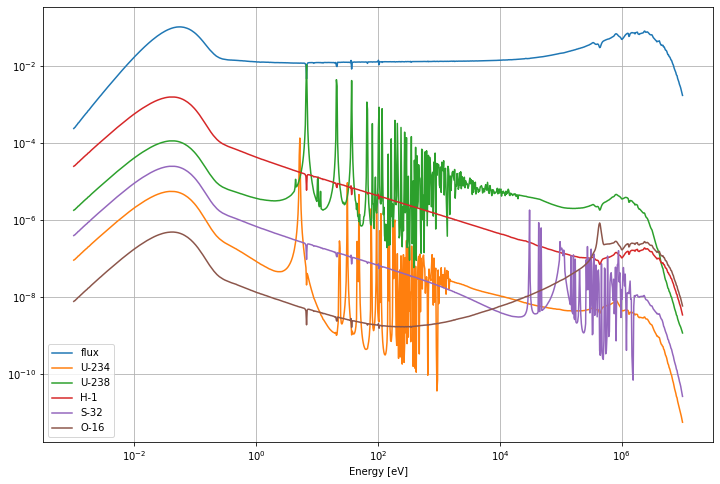

In [37]:
plt.rcParams['figure.figsize']=[12,8];
plt.loglog(energy_x,flux_vals,label='flux');
plt.loglog(energy_x,capture_U234,label='U-234');
plt.loglog(energy_x,capture_U238,label='U-238');
plt.loglog(energy_x,capture_H1,label='H-1');
plt.loglog(energy_x,capture_S32,label='S-32');
plt.loglog(energy_x,capture_O16,label='O-16');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');



### Comments for Baseline Case
ven though U-234 has a significant capture cross section, due to its relatively low concentration, the reaction rate is not dominant; it is U-238 instead.  U-238 is also responsible for the flux dips between 10 and 100 eV as well.  

A higher energy - around 1 MeV, it looks like resnances for O-16 and, possibly S-32 become important.  